In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

df = pd.read_excel('Project1Data_Adj.xlsx')

# Demand Function
X_d = df[['ln(cprice/oprice)','ln(tprice/oprice)','ln(incom/oprice)','q2','q3','q4']]
y_d = df['ln(qu)']

X_d = sm.add_constant(X_d)

model_d = sm.OLS(y_d,X_d)

result_d = model_d.fit()
residuals = result_d.resid

print(result_d.summary())


                            OLS Regression Results                            
Dep. Variable:                 ln(qu)   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     5.005
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           0.000223
Time:                        19:06:42   Log-Likelihood:                 79.044
No. Observations:                  84   AIC:                            -144.1
Df Residuals:                      77   BIC:                            -127.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.1915      3.84

In [3]:
# Correlation between endogenous variable and potential instruments
print(df[['ln(cprice/oprice)', 'ln(bprice/oprice)', 'ln(wprice/oprice)']].corr())


                   ln(cprice/oprice)  ln(bprice/oprice)  ln(wprice/oprice)
ln(cprice/oprice)           1.000000           0.948766           -0.15738
ln(bprice/oprice)           0.948766           1.000000           -0.28190
ln(wprice/oprice)          -0.157380          -0.281900            1.00000


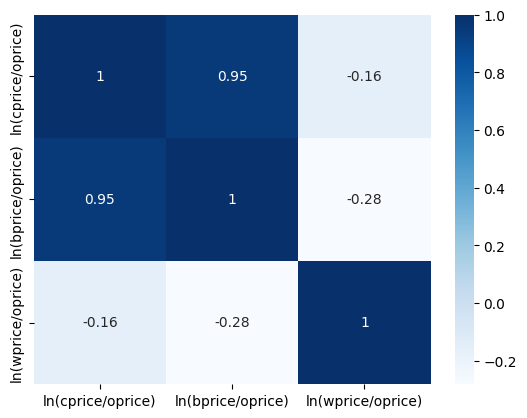

In [4]:
import seaborn as sns

selected_vars = ['ln(cprice/oprice)', 'ln(bprice/oprice)', 'ln(wprice/oprice)']
subset_df = df[selected_vars]

sns.heatmap(subset_df.corr(), cmap='Blues', annot=True)

plt.show()

In [5]:
# Check the bprice with the cprice

X_ex = df[['ln(tprice/oprice)', 'ln(incom/oprice)', 'q2', 'q3', 'q4']]  # Exogenous variables
X_end = df['ln(cprice/oprice)']
Z = df[['ln(bprice/oprice)']] # Instrument

# Combine the instrument with the exogenous variables
X_first_stage = sm.add_constant(pd.concat([X_ex, Z], axis=1))

# Run the first-stage regression with the instrument and exogenous variables
first_stage_multiple = sm.OLS(X_end, X_first_stage).fit()

# Print the summary to check the F-statistic for the instrument and the overall model
print(first_stage_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:      ln(cprice/oprice)   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     143.6
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           1.05e-39
Time:                        19:06:43   Log-Likelihood:                 154.51
No. Observations:                  84   AIC:                            -295.0
Df Residuals:                      77   BIC:                            -278.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5971      1.56

In [6]:
# Test the exogeneity
from linearmodels.iv import IV2SLS

iv2sls = IV2SLS(dependent = y_d, 
               endog = X_end,
               exog = sm.add_constant(X_ex),
               instruments = Z).fit()

print(iv2sls.wu_hausman())

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.5543
P-value: 0.4589
Distributed: F(1,76)


In [ ]:
import statsmodels.api as sm
from scipy.stats import chi2

# Assuming you already have the following:
# X_ex = df[['ln(tprice/oprice)', 'ln(incom/oprice)', 'q2', 'q3', 'q4']]  # Exogenous variables
# X_end = df['ln(cprice/oprice)']
# Z = df[['ln(bprice/oprice)']] 
# Y: Dependent variable (array or Series)
# X: Endogenous variable (array or Series, typically the regressor in the 2SLS model)
# instruments: DataFrame of instruments used for X (e.g., columns for Z1, Z2, etc.)
# model_2sls: The 2SLS model result object from statsmodels

# Step 1: Get the residuals from the 2SLS model
residuals = first_stage_multiple.resid  # Obtain residuals from the fitted 2SLS model

# Step 2: Regress the residuals on all instrumental variables
# Add a constant to the instrument matrix
exog_instruments = sm.add_constant(Z)
sargan_test_model = sm.OLS(residuals, exog_instruments).fit()

# Step 3: Calculate the Sargan test statistic (n * R^2)
nR2 = len(Z) * sargan_test_model.rsquared

# Step 4: Determine degrees of freedom (df = number of instruments - number of endogenous variables)
# Assuming one endogenous variable, degrees of freedom = number of instruments - 1
degrees_of_freedom = Z.shape[1] - 1

# Step 5: Calculate the p-value for the chi-square test
p_value = 1 - chi2.cdf(nR2, degrees_of_freedom)

# Display results
print("Sargan Test Statistic:", nR2)
print("Degrees of Freedom:", degrees_of_freedom)
print("P-Value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis: Instruments may not be exogenous.")
else:
    print("Fail to reject the null hypothesis: Instruments appear to be exogenous.")


Sargan Test Statistic: 9.325873406851315e-15
Degrees of Freedom: 0
P-Value: nan
Fail to reject the null hypothesis: Instruments appear to be exogenous.


In [7]:
from linearmodels.iv import IV2SLS
# Define variable
y = df['ln(qu)']  # dependent variable
X = df[['ln(tprice/oprice)', 'ln(incom/oprice)', 'q2', 'q3', 'q4']]  # independent variable => without endogeneity problem
Z = df[['ln(bprice/oprice)']]  # IV
W = df[['ln(cprice/oprice)']]  # independent variable => with endogeneity problem

#Add intercept
X = sm.add_constant(X)

# Model
model = IV2SLS(dependent=y, exog=X, endog=W, instruments=Z).fit()

# check result
print(model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                 ln(qu)   R-squared:                      0.2800
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2239
No. Observations:                  84   F-statistic:                    39.613
Date:                Mon, Nov 11 2024   P-value (F-stat)                0.0000
Time:                        19:06:43   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                -5.3122     4.0855    -1.3003     0.1935     -13.320      2.6952
ln(tprice/oprice)     0.